In [16]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import os

TRAIN_INPUT_PATH = "./train"
TEST_INPUT_PATH = "./test"
EMOTIONS = [f.name for f in os.scandir(TRAIN_INPUT_PATH) if f.is_dir()]
IMAGE_SIZE = (48, 48)

print(EMOTIONS)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, image_size)
            img = img.astype('float32') / 255.0  # Normalize
            img = np.expand_dims(img, -1)
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [17]:
# Load the images 1
X_train, y_train = load_images(TRAIN_INPUT_PATH, EMOTIONS, IMAGE_SIZE)
X_test, y_test = load_images(TEST_INPUT_PATH, EMOTIONS, IMAGE_SIZE)
input_shape = X_train[0].shape
print(input_shape)

(48, 48, 1)


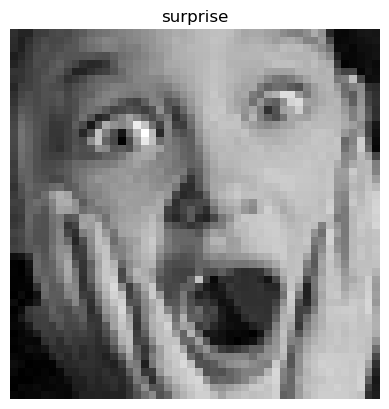

In [4]:
import random
import matplotlib.pyplot as plt
# choose a random image index
idx = np.random.randint(len(X_train))

# display the image and its corresponding label from arrays
plt.imshow(X_train[idx], cmap='gray')
plt.title(EMOTIONS[np.argmax(y_train[idx])])
plt.axis('off')  # remove the grid
plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential()

# First Convolutional Block
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Block
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.35))

# Flattening
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 for the number of emotions

model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=6, min_lr=0.0001, mode='max')

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [7]:
batch_size = 64
epochs = 150
steps_per_epoch = 358
validation_steps = 89

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=1)

Epoch 1/150
449/449 [==============================] - ETA: 0s - loss: 1.9736 - accuracy: 0.2150
Epoch 1: val_accuracy improved from -inf to 0.24714, saving model to best_model.keras
449/449 [==============================] - 191s 425ms/step - loss: 1.9736 - accuracy: 0.2150 - val_loss: 1.8362 - val_accuracy: 0.2471 - lr: 1.0000e-04
Epoch 2/150
449/449 [==============================] - ETA: 0s - loss: 1.8088 - accuracy: 0.2486
Epoch 2: val_accuracy improved from 0.24714 to 0.25759, saving model to best_model.keras
449/449 [==============================] - 191s 425ms/step - loss: 1.8088 - accuracy: 0.2486 - val_loss: 1.7344 - val_accuracy: 0.2576 - lr: 1.0000e-04
Epoch 3/150
449/449 [==============================] - ETA: 0s - loss: 1.7401 - accuracy: 0.2894
Epoch 3: val_accuracy improved from 0.25759 to 0.34731, saving model to best_model.keras
449/449 [==============================] - 190s 424ms/step - loss: 1.7401 - accuracy: 0.2894 - val_loss: 1.6279 - val_accuracy: 0.3473 - lr: 

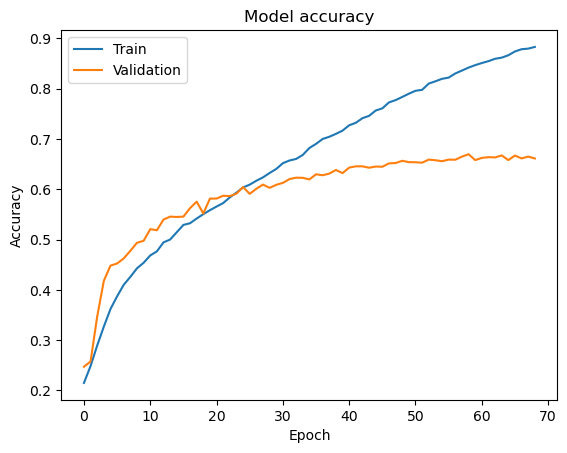

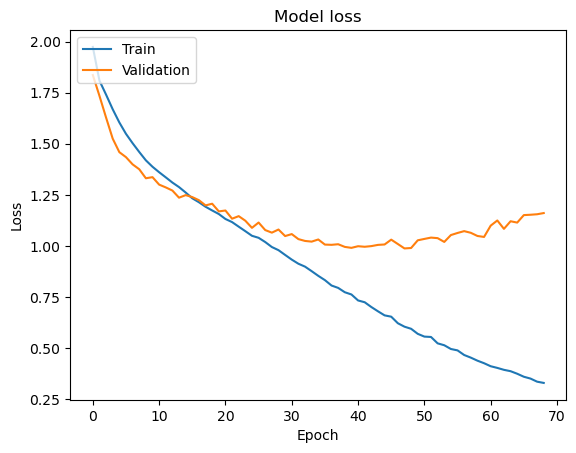

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('./test',
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 7178 images belonging to 7 classes.


225/225 [==============================] - 13s 59ms/step
Confusion Matrix
[[ 551    6  105   34   97  158    7]
 [  31   58    7    3    3    8    1]
 [ 106    1  512   28  109  212   56]
 [  48    1   42 1479  123   55   26]
 [  66    2   82   67  814  198    4]
 [ 116    0  139   49  223  710   10]
 [  14    1  106   40   25   22  623]]
Classification Report
              precision    recall  f1-score   support

       angry       0.59      0.58      0.58       958
     disgust       0.84      0.52      0.64       111
        fear       0.52      0.50      0.51      1024
       happy       0.87      0.83      0.85      1774
     neutral       0.58      0.66      0.62      1233
         sad       0.52      0.57      0.54      1247
    surprise       0.86      0.75      0.80       831

    accuracy                           0.66      7178
   macro avg       0.68      0.63      0.65      7178
weighted avg       0.67      0.66      0.66      7178



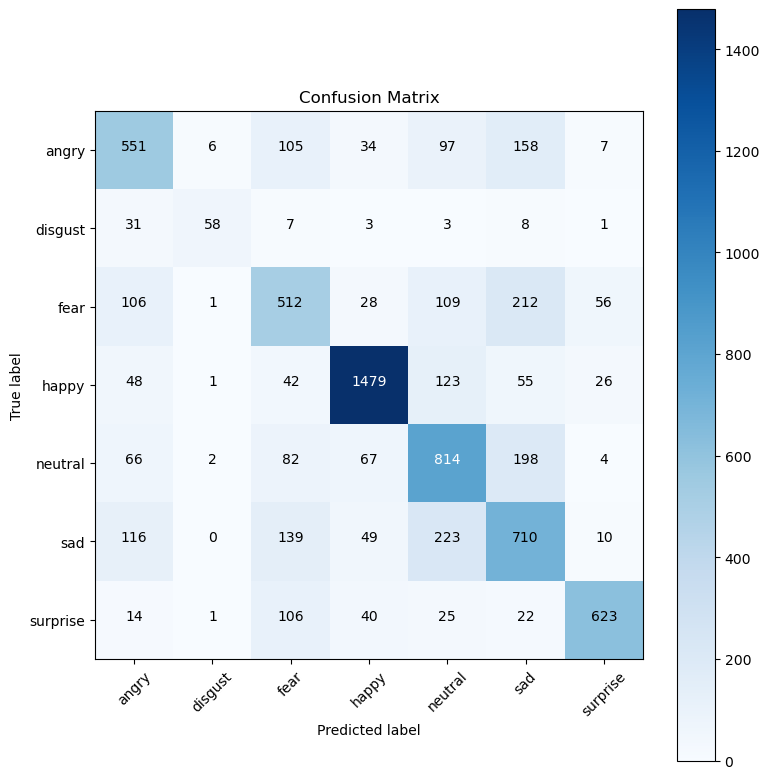

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_test, axis=1)

cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

225/225 [==============================] - 14s 61ms/step
Confusion Matrix
[[ 547    7   90   50  100  153   11]
 [  35   55    4    5    1   10    1]
 [ 123    4  448   34  104  237   74]
 [  28    0   30 1536   97   55   28]
 [  67    3   58   84  819  192   10]
 [ 109    0  101   66  212  746   13]
 [  14    2   81   45   18   14  657]]
Classification Report
              precision    recall  f1-score   support

       angry       0.59      0.57      0.58       958
     disgust       0.77      0.50      0.60       111
        fear       0.55      0.44      0.49      1024
       happy       0.84      0.87      0.85      1774
     neutral       0.61      0.66      0.63      1233
         sad       0.53      0.60      0.56      1247
    surprise       0.83      0.79      0.81       831

    accuracy                           0.67      7178
   macro avg       0.68      0.63      0.65      7178
weighted avg       0.67      0.67      0.67      7178



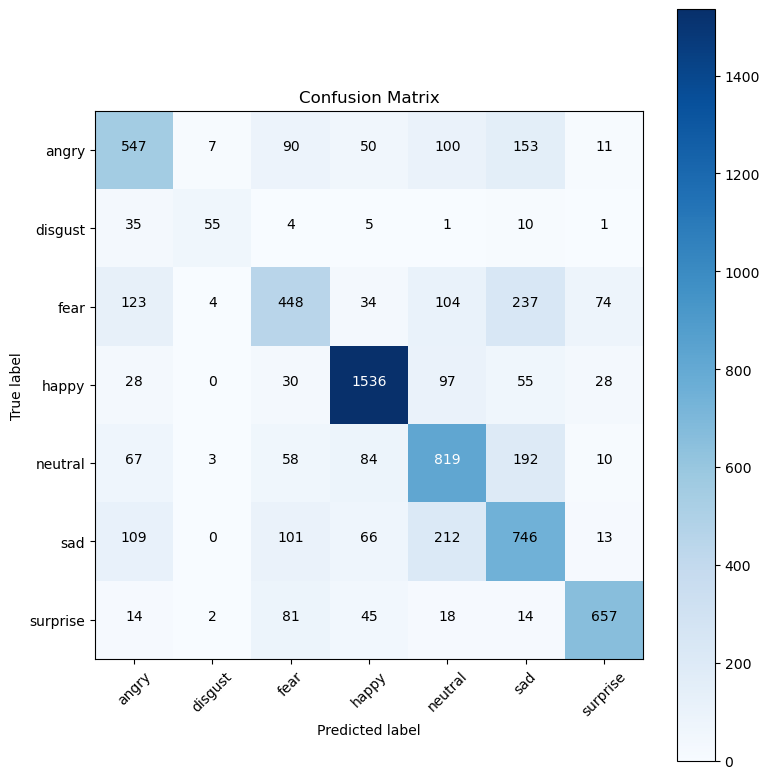

In [14]:
from tensorflow.keras.models import load_model

# Load the saved model
best_model = load_model("best_model.keras")

y_pred = best_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_test, axis=1)

cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

898/898 [==============================] - 51s 57ms/step
Confusion Matrix
[[1094 1277  263   83  322  553  403]
 [  17  311   24    1   18   49   16]
 [ 221  443 1293   49  313 1076  702]
 [  96 1756  418 1259  304  554 2828]
 [ 266  671  247   62  666 1964 1089]
 [ 208  474  224   53 1095 2389  387]
 [  15   48 1064   12   26   34 1972]]
Classification Report
              precision    recall  f1-score   support

       angry       0.57      0.27      0.37      3995
     disgust       0.06      0.71      0.11       436
        fear       0.37      0.32      0.34      4097
       happy       0.83      0.17      0.29      7215
     neutral       0.24      0.13      0.17      4965
         sad       0.36      0.49      0.42      4830
    surprise       0.27      0.62      0.37      3171

    accuracy                           0.31     28709
   macro avg       0.39      0.39      0.30     28709
weighted avg       0.47      0.31      0.32     28709



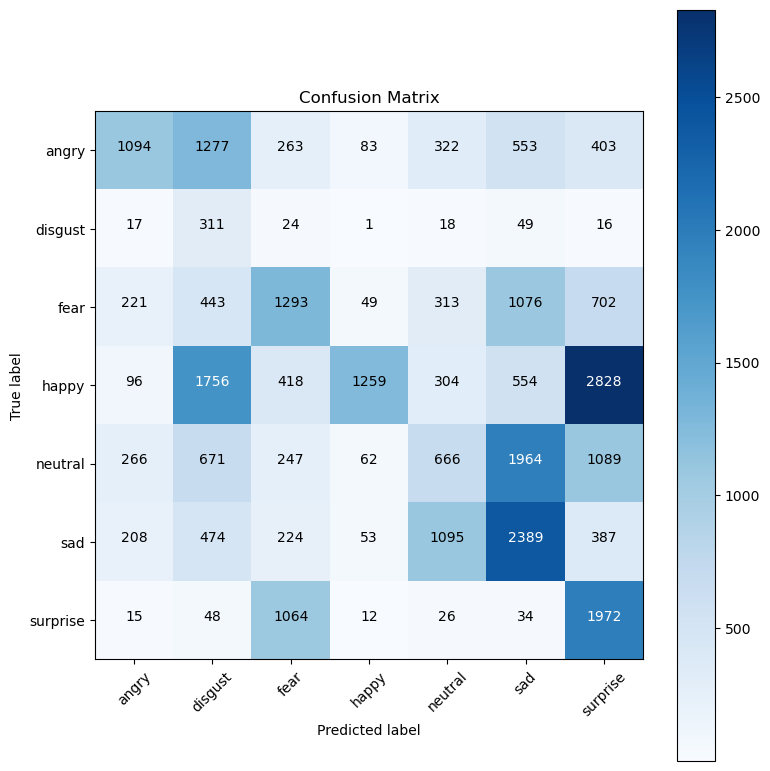

In [21]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Load the saved model
best_model = load_model("best_model_TL.keras")
y_pred = best_model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}
y_test_indices = np.argmax(y_train, axis=1)


cm_test = confusion_matrix(y_test_indices, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_test_indices, y_pred, target_names=target_names))

# Plotting the confusion matrix with numbers
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)  # Using a color map for better visibility
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

# Labeling the axes
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Looping over data dimensions and creating text annotations.
thresh = cm_test.max() / 2.  # Threshold for changing text color for better visibility
for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
    plt.text(j, i, format(cm_test[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test[i, j] > thresh else "black")

plt.tight_layout()
plt.show()